In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

# 1. Loading Data

In [4]:
data = pd.read_csv("data/diamonds.csv")
data.head()

Unnamed: 0  carat      cut color clarity  depth  table  price     x     y  \
0           1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98   
1           2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84   
2           3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07   
3           4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23   
4           5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35   

      z  
0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75

In [4]:
data.shape

(53940, 11)

In [11]:
# 確認每個欄位的最大值、最小值、平均值、標準差等等
data.describe()

Unnamed: 0         carat         depth         table         price  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean   26970.500000      0.797940     61.749405     57.457184   3932.799722   
std    15571.281097      0.474011      1.432621      2.234491   3989.439738   
min        1.000000      0.200000     43.000000     43.000000    326.000000   
25%    13485.750000      0.400000     61.000000     56.000000    950.000000   
50%    26970.500000      0.700000     61.800000     57.000000   2401.000000   
75%    40455.250000      1.040000     62.500000     59.000000   5324.250000   
max    53940.000000      5.010000     79.000000     95.000000  18823.000000   

                  x             y             z  
count  53940.000000  53940.000000  53940.000000  
mean       5.731157      5.734526      3.538734  
std        1.121761      1.142135      0.705699  
min        0.000000      0.000000      0.000000  
25%        4.710000      4.720000      2.910000  
50%        5.700000      5.710000      3.530000  
75%        6.540000      6.540000      4.040000  
max       10.740000     58.900000     31.800000

In [12]:
# 非數值型資料的統計資訊
# cut 的種類
print(data['cut'].unique())
# color 的種類
print(data['color'].unique())
# clarity 的種類
print(data['clarity'].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


決定鑽石價格的4個條件:
1. carat 克拉 0.2 ~ 5.01
2. cut 切工 Ideal Premium Good VeryGood Fair
3. color 顏色 E I J H F G D
4. clarity 淨度 SI2 SI1 VS1 VS2 VVS2 VVS1 I1 IF

# 2. Data Preprocessing
資料處理

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [5]:
# Unnamed: 0 用不到，所以刪除
data = data.drop('Unnamed: 0', axis=1)
# x y z 不可能為 0 所以刪除為 0 的資料
data = data.drop(data[(data['x']==0) | (data['y']==0) | (data['z']==0)].index)
data.shape # 有 20 筆資料被刪除

(53920, 10)

In [1]:
# copy from https://www.kaggle.com/code/abdmental01/plotting-masterclass 
# Basic Modules 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# Complete Plotting Class
class Plotting_by_Abdullah:
    def __init__(self, DATA):
        self.DATA = DATA 
   # Scatter plot With Hue and Not Hue 
    def scatter_plot_all(self, T_V, hue=None, palette=None):
        # Num Cols 
        num_cols = [col for col in self.DATA.columns if self.DATA[col].dtype != 'object' and self.DATA[col].dtype != 'category' and self.DATA[col].dtype != 'bool']

        # Features Except T_V
        FEATURE= [col for col in num_cols if col != T_V]
        num_features = len(FEATURE)

        # Calculate number of rows and columns for subplots
        ncols = min(3, num_features) 
        nrows = (num_features + ncols - 1) // ncols

        # Create subplots
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))

        # Assign colors from the custom palette
        if palette is None:
            colors = sns.color_palette() 
        else:
            colors = palette

        # Plot each variable against the T_V
        for i, (FE, color) in enumerate(zip(FEATURE, colors)):
            if nrows == 1:
                ax = axes[i]
            else:
                ax = axes.flatten()[i]

            if hue:
                sns.scatterplot(x=self.DATA[FE], y=self.DATA[T_V], hue=self.DATA[hue], ax=ax, palette=palette)
                ax.set_title(f"{FE} vs {T_V} (Hue: {hue})")
                ax.set_xlabel(FE)
                ax.set_ylabel(T_V)
            else:
                sns.scatterplot(x=self.DATA[FE], y=self.DATA[T_V], ax=ax, palette=palette)
                ax.set_title(f"{FE} vs {T_V}")
                ax.set_xlabel(FE)
                ax.set_ylabel(T_V)

        # Hide empty subplots
        for i in range(num_features, nrows * ncols):
            if nrows == 1:
                fig.delaxes(axes[i])
            else:
                fig.delaxes(axes.flatten()[i])

        plt.tight_layout()
        plt.show()
        
    # Quick Overview of Plotting
    def QUICK_SHOW(self, color_palette=None, H=True, B=True, C=True, P=True):
        
        # Set the color palette if provided, otherwise use default
        if color_palette:
            sns.set_palette(color_palette)

        # Data Types 
        num_cols = self.DATA.select_dtypes(include=['float', 'integer']).columns.tolist()
        cat_cols = self.DATA.select_dtypes(include=['object', 'category']).columns.tolist()

        # Error handling for data types
        if not all(col in self.DATA.columns for col in num_cols + cat_cols):
            raise ValueError("Columns provided must exist in the dataframe.")

        # Error handling for empty data
        if self.DATA.empty:
            raise ValueError("Dataframe is empty.")

        num_rows = len(num_cols)
        cat_rows = len(cat_cols)
        total_rows = max(num_rows, cat_rows)

        if total_rows == 0:
            raise ValueError("No columns provided for plotting.")

        # Subplots Configure
        fig, axes = plt.subplots(total_rows, 4, figsize=(6*4, 6*total_rows))
        plt.subplots_adjust(hspace=0.5)

        # Hist and Box Plots 
        for i, col in enumerate(num_cols):
            if i < num_rows:
                if H:
                    sns.histplot(self.DATA[col], ax=axes[i, 0], kde=True)
                    axes[i, 0].set_title(f'Histogram of {col}')
                    axes[i, 0].set_xlabel(col)
                    axes[i, 0].set_ylabel('Frequency')
                if not H:
                    axes[i, 0].set_visible(False)
                if B:
                    sns.boxplot(self.DATA[col], ax=axes[i, 1])
                    axes[i, 1].set_title(f'Box Plot of {col}')
                    axes[i, 1].set_xlabel(col)
                    axes[i, 1].set_ylabel('')
                else:
                    axes[i, 1].set_visible(False)
            else:
                for j in range(2):
                    axes[i, j].set_visible(False)
        # Pie and Count Plot 
        for i, col in enumerate(cat_cols, start=0):
            # Convert the categorical column to pandas categorical data
            self.DATA[col] = pd.Categorical(self.DATA[col])

            counts = self.DATA[col].value_counts()

            # Plot Bar Chart
            if C:
                sns.countplot(data=self.DATA, x=col, ax=axes[i, 2], order=self.DATA[col].value_counts().index)
                axes[i, 2].set_title(f'Count Plot of {col}')
                axes[i, 2].set_xlabel(col)
                axes[i, 2].set_ylabel('Count')
                axes[i, 2].tick_params(axis='x', rotation=45)
            if not C:
                axes[i, 2].set_visible(False)

            # Plot PIE Chart
            if P:
                axes[i, 3].pie(counts, labels=counts.index, autopct='%1.1f%%')
                axes[i, 3].set_title(f'Pie Plot of {col}')
                axes[i, 3].set_xlabel('')
                axes[i, 3].set_ylabel('')

            # Hide axes for PIE Plot if disabled
            if not P:
                axes[i, 3].set_visible(False)

        # Clear remaining empty subplots for categorical columns
        for j in range(cat_rows, total_rows):
            for k in range(2, 4):
                axes[j, k].set_visible(False)

        plt.tight_layout()
        plt.show()
        
    # Volion Plots   
    def violin_plot(self, target_variable, palette=None):
        # Select numerical columns
        numerical_columns = [col for col in self.DATA.columns if self.DATA[col].dtype != 'object' and self.DATA[col].dtype != 'category' and self.DATA[col].dtype != 'bool']

        # Determine the number of features
        num_features = len(numerical_columns)

        # Determine the number of rows and columns for subplots
        ncols = min(3, num_features)
        nrows = (num_features + ncols - 1) // ncols

        # Create subplots
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
        plt.subplots_adjust(hspace=0.5)

        # Plot violin plots for each numerical column
        for i, column in enumerate(numerical_columns):
            if nrows == 1:
                ax = axes[i]
            else:
                ax = axes.flatten()[i]
            sns.violinplot(x=target_variable, y=column, data=self.DATA, ax=ax, palette=palette)
            ax.set_title(f"Violin plot of {column} by {target_variable}")
            ax.set_xlabel(target_variable)
            ax.set_ylabel(column)

        # Hide empty subplots
        for i in range(num_features, nrows * ncols):
            if nrows == 1:
                fig.delaxes(axes[i])
            else:
                fig.delaxes(axes.flatten()[i]) 

        plt.tight_layout()
        plt.show()

    def violin_plot_Category(self, target_variable, palette=None):
        # Select categorical columns
        categorical_columns = [col for col in self.DATA.columns if self.DATA[col].dtype == 'object' or self.DATA[col].dtype == 'category']

        # Determine the number of features
        num_features = len(categorical_columns)

        # Determine the number of rows and columns for subplots
        ncols = min(3, num_features)
        nrows = (num_features + ncols - 1) // ncols

        # Create subplots
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
        plt.subplots_adjust(hspace=0.5)

        # Flatten axes
        axes = np.ravel(axes)

        # Plot violin plots for each categorical column
        for i, column in enumerate(categorical_columns):
            ax = axes[i]

            # Plot only if the axis exists
            if ax is not None:
                sns.violinplot(x=column, y=target_variable, data=self.DATA, ax=ax, palette=palette)
                ax.set_title(f"Violin plot of {target_variable} by {column}")
                ax.set_xlabel(column)
                ax.set_ylabel(target_variable)

        # Hide empty subplots
        for ax in axes[num_features:]:
            # Remove the axis if it exists
            if ax is not None:
                fig.delaxes(ax)

        plt.tight_layout()
        plt.show()

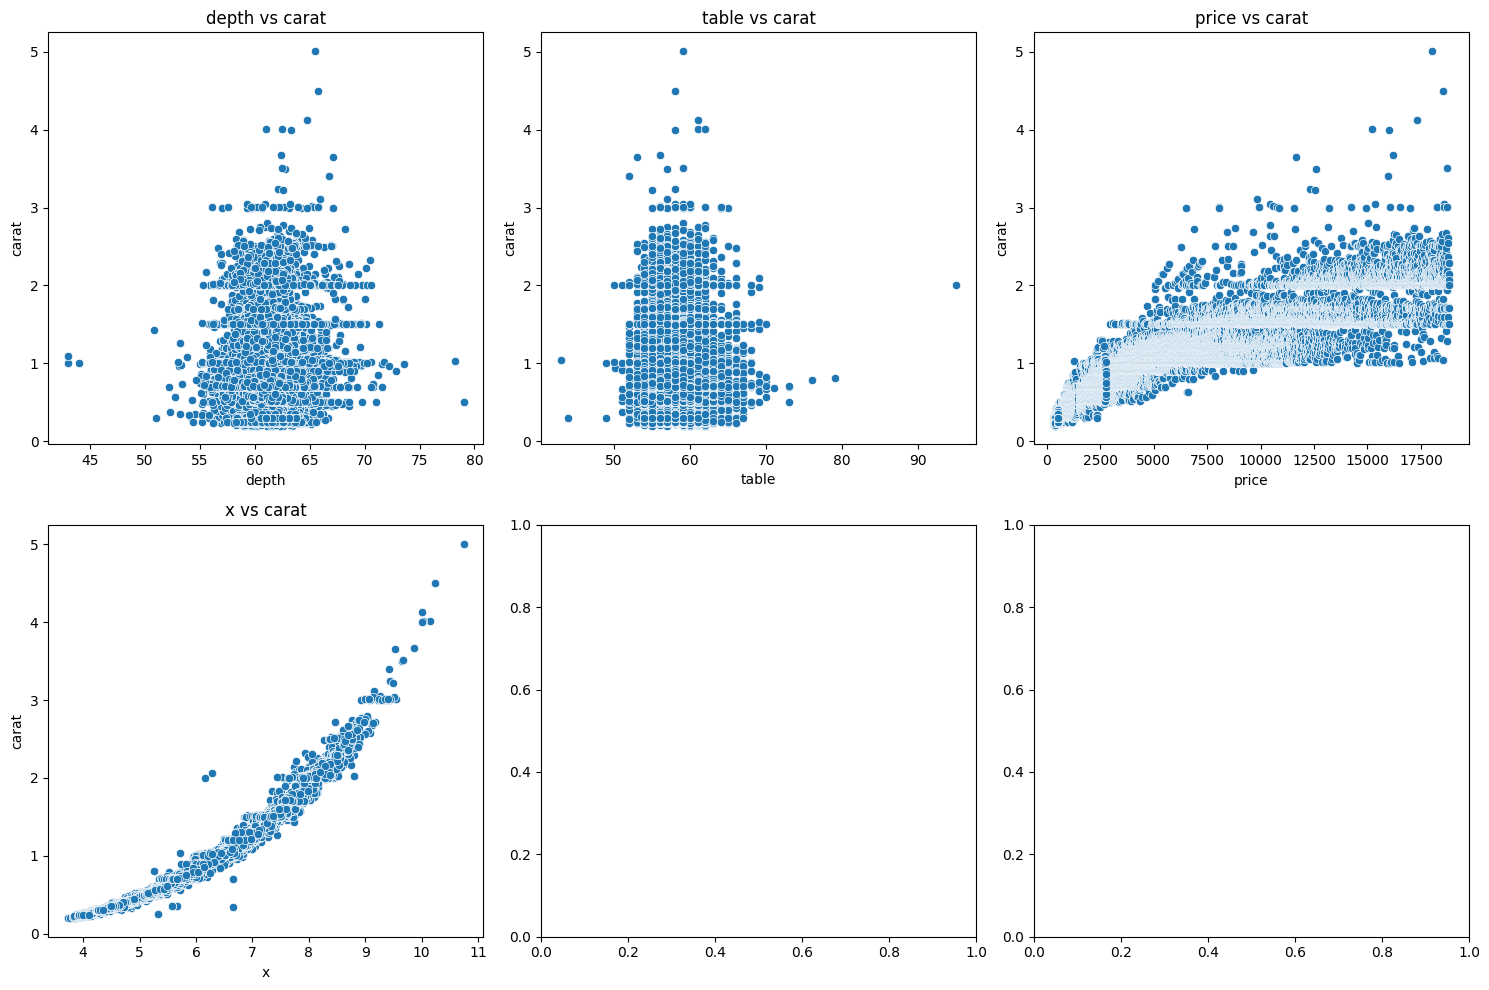

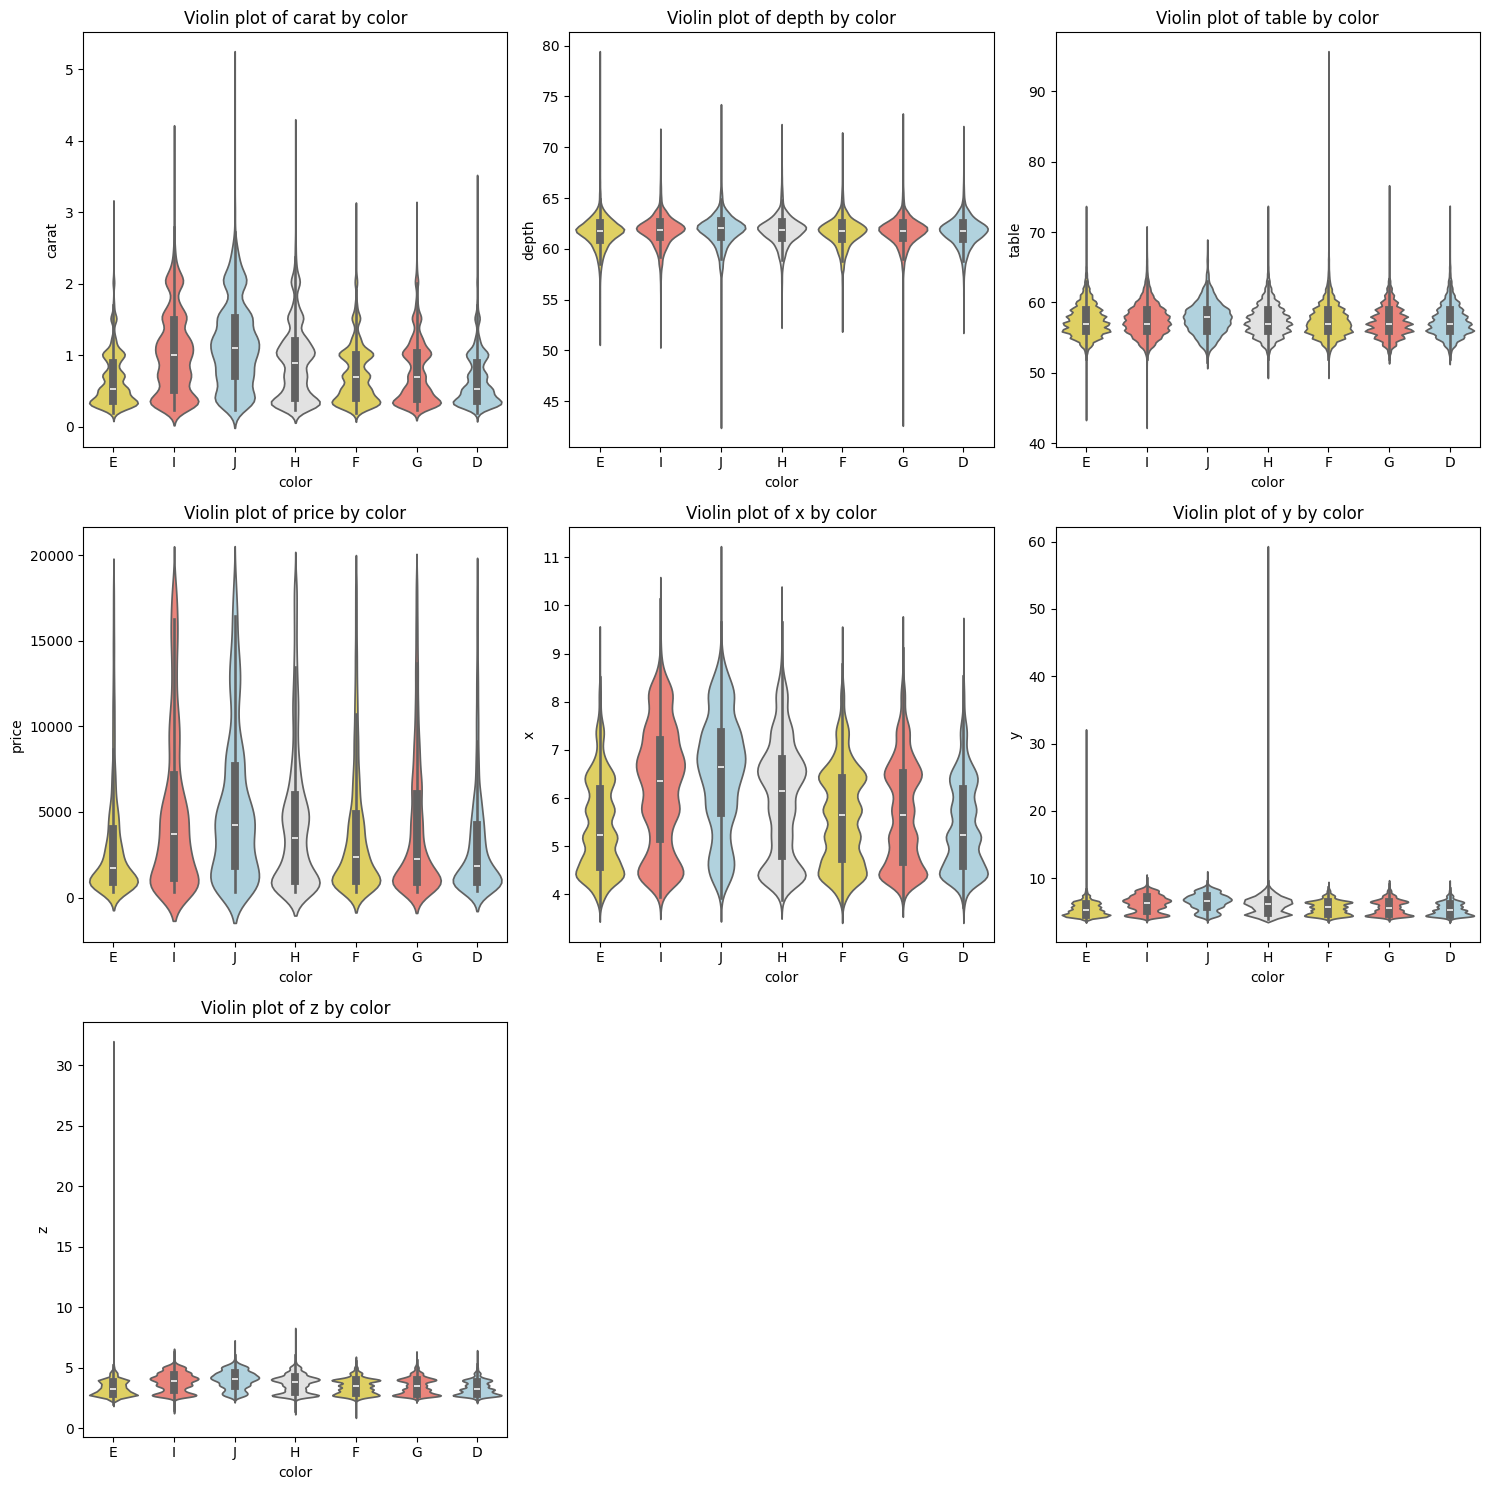

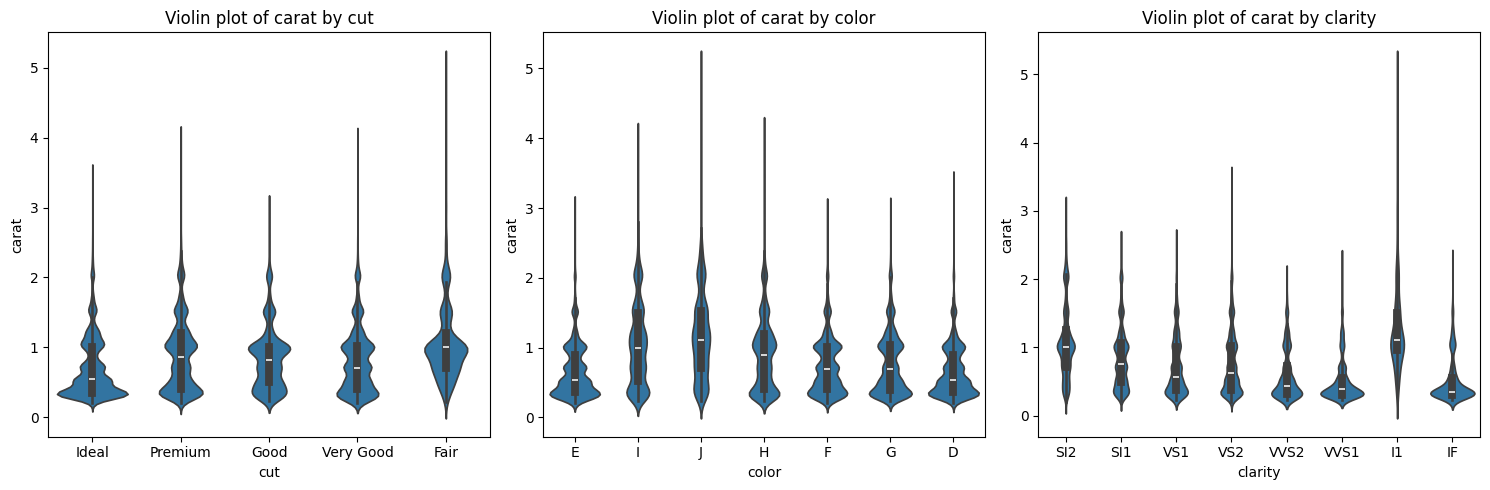

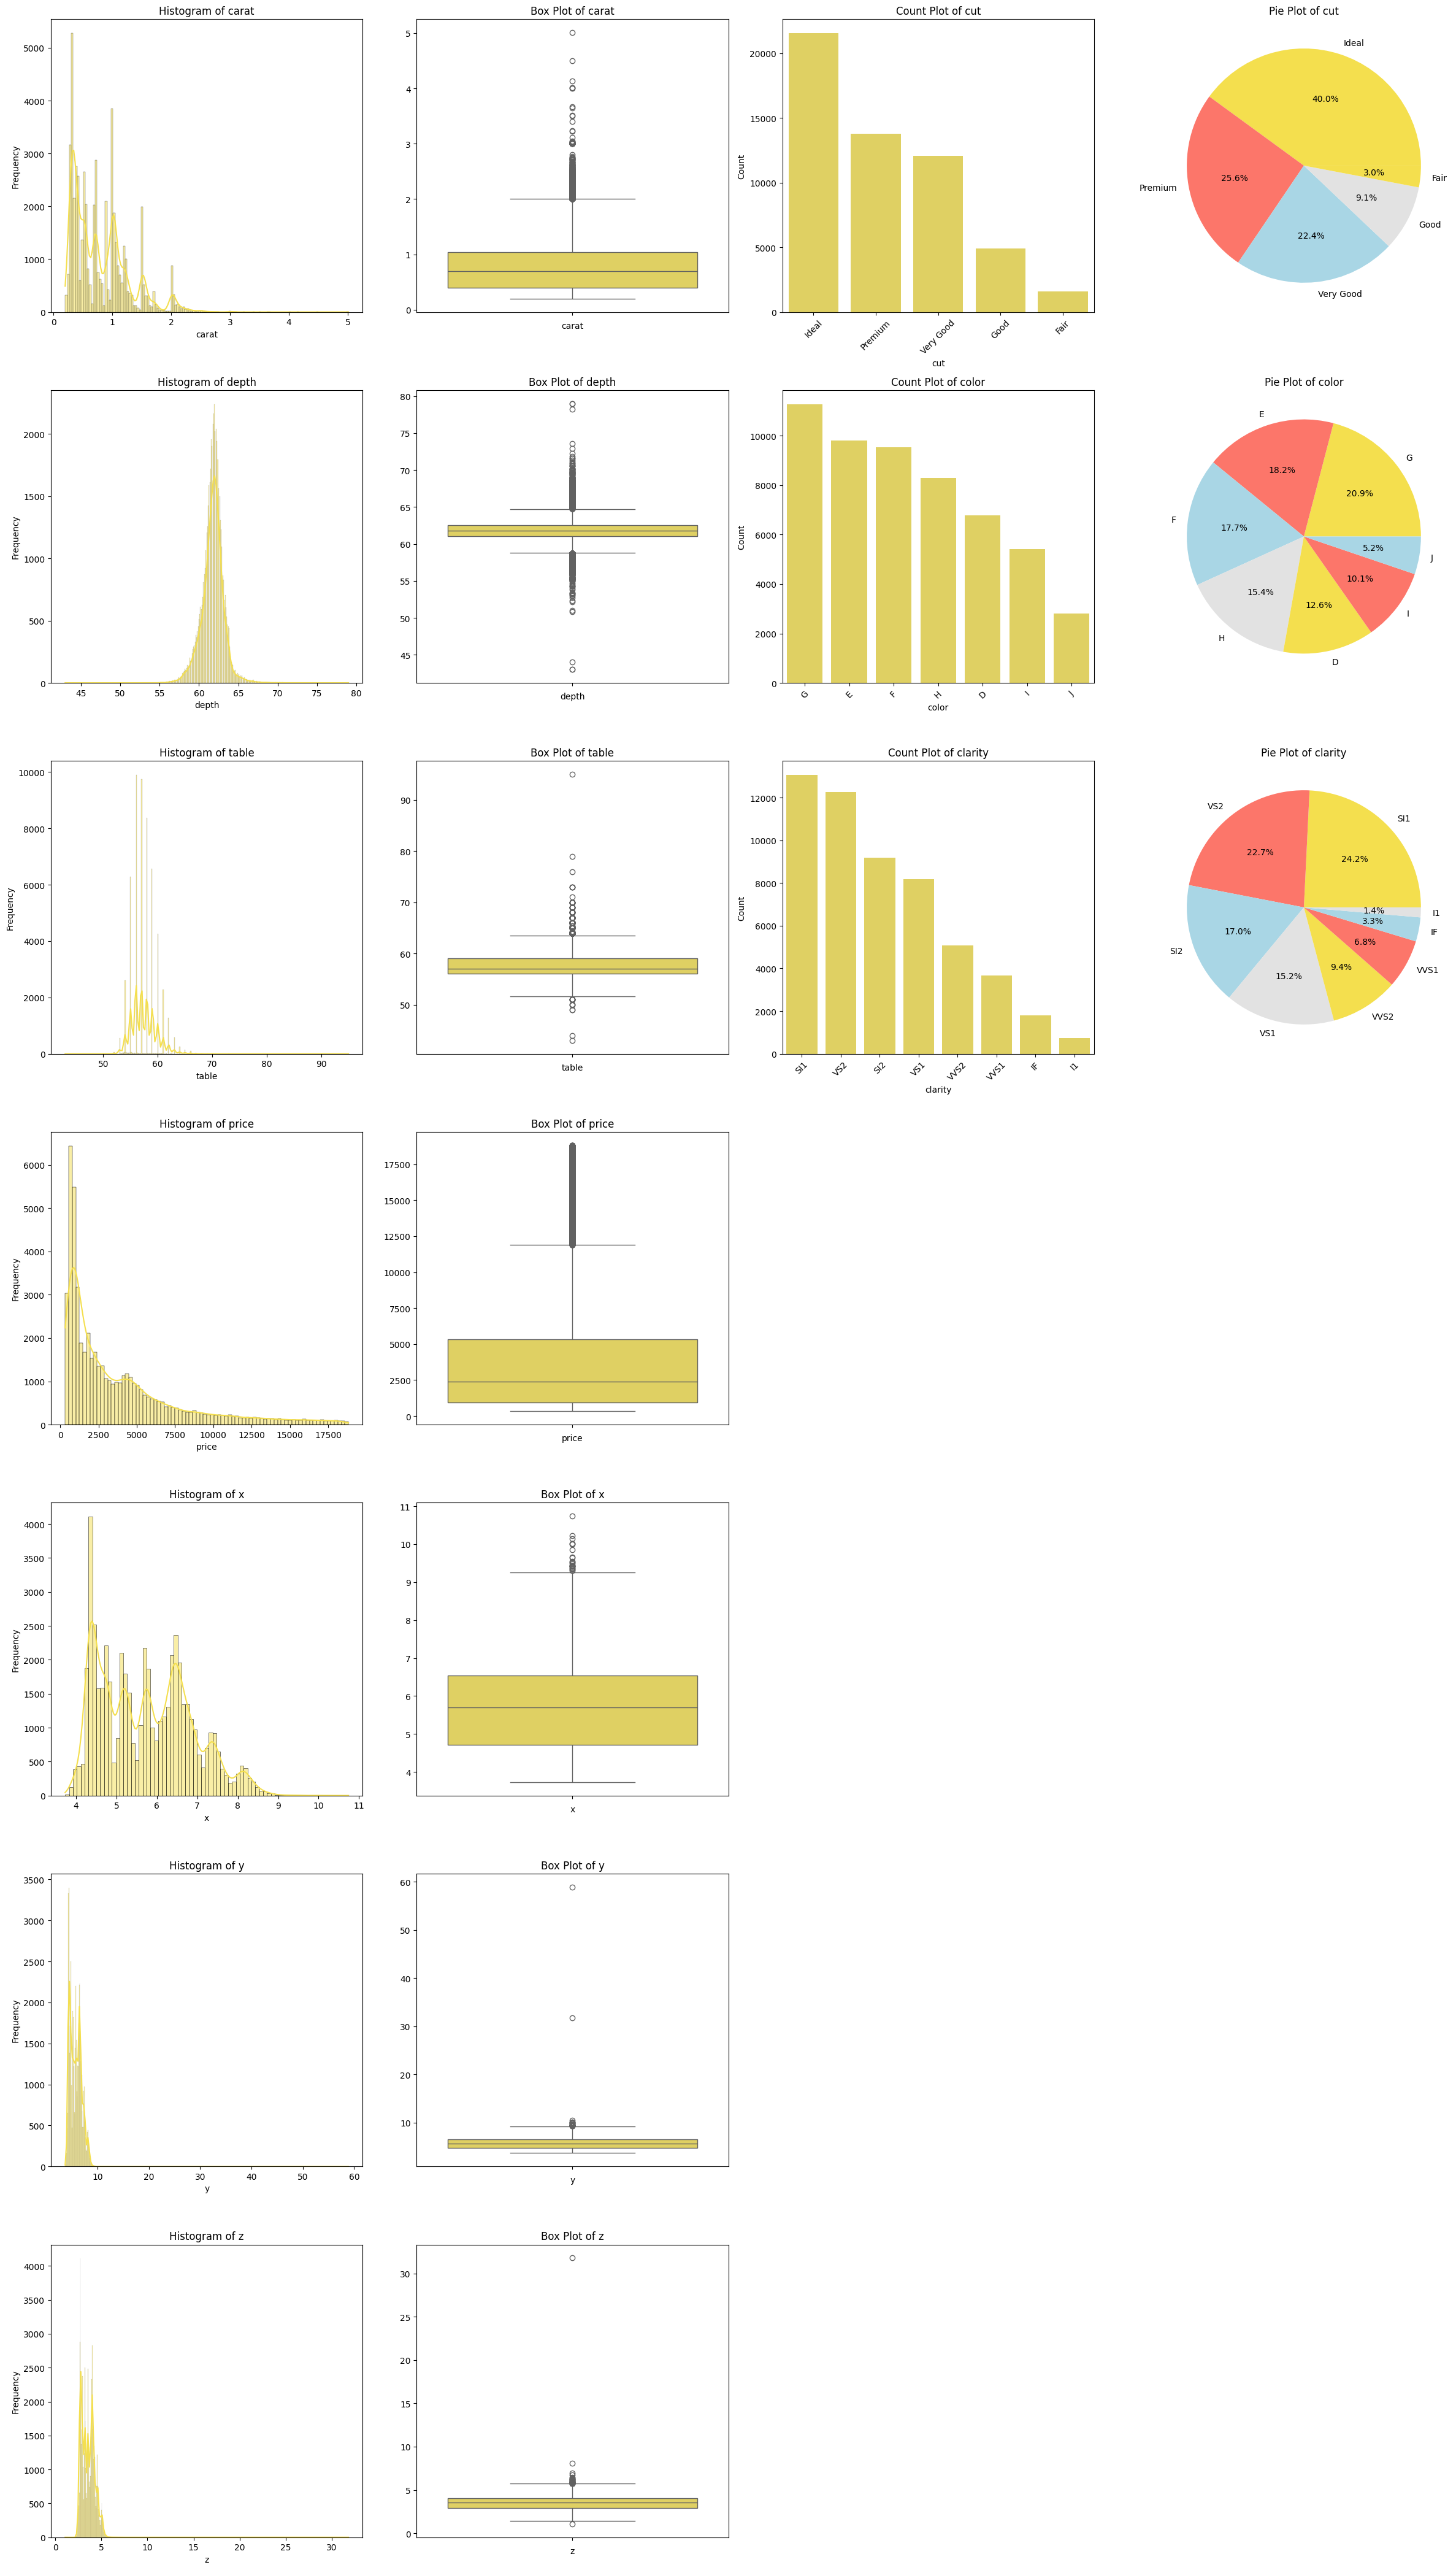

In [8]:
# 測試 Plotting_by_Abdullah 的功能
custom_palette = ["#F4DF4EFF", "#FC766AFF", "#A9D6E5", "#E2E2E2"]
# 複製一份資料
Diamond = data.copy()
plt_Abd = Plotting_by_Abdullah(DATA=Diamond)
# Ititilize T_V and HUE
T_V = 'carat' # 以 carat 為主要特徵測試看看
H_U_E = 'color'
# Scatter Plot with Hue
plt_Abd.scatter_plot_all(T_V, hue = H_U_E ,palette=custom_palette)
# violin Plot
plt_Abd.violin_plot(H_U_E,palette=custom_palette)
# violin Plot with Category
plt_Abd.violin_plot_Category(T_V, palette=None)
# 測試 QUICK_SHOW 的功能
plt_Abd.QUICK_SHOW(color_palette=custom_palette, H=True, B=True, C=True, P=True)

可以藉由 Plotting_by_Abdullah 這個別人已經寫好的 class 快速的透過各式圖表了解資料分布
接下來會直接使用單獨的圖表快速確認所需的內容 並且 hue 從 color 變成 cut

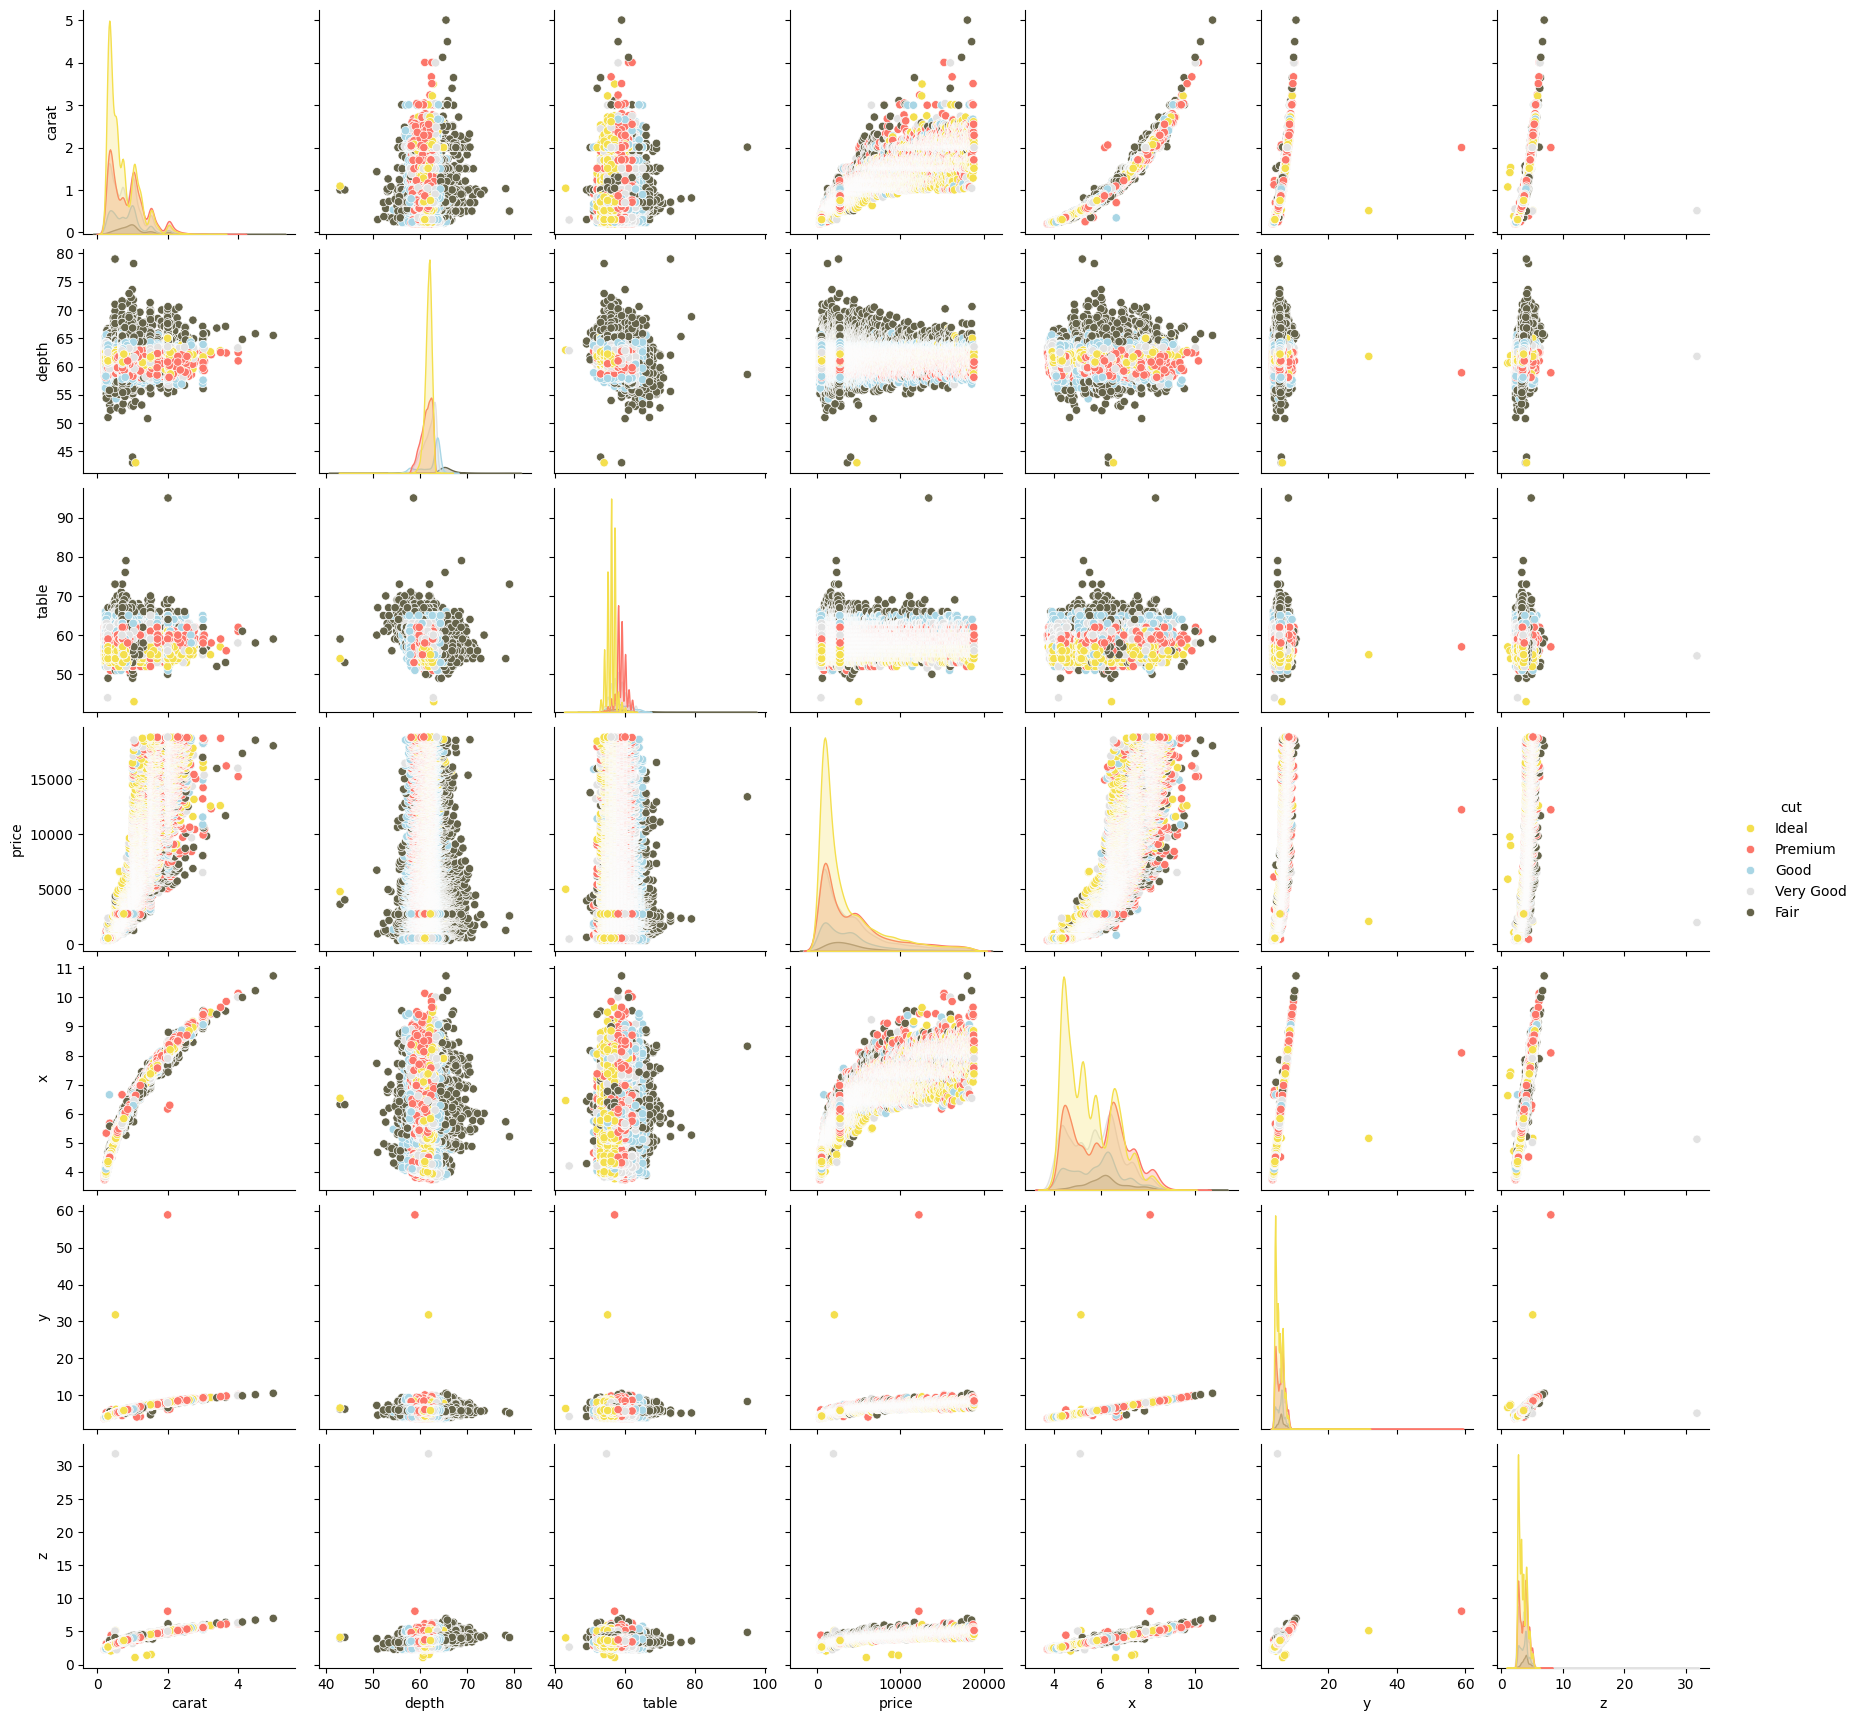

In [9]:
# pair plot確認資料分布
shade = ["#F4DF4EFF", "#FC766AFF", "#A9D6E5", "#E2E2E2", "#65634a"]
ax = sns.pairplot(data, hue= "cut",palette=shade)# cut 只有 5 種，所以用 cut 當 hue

從上圖可以看到 有些資料點距離其他資料太遠(離群值) 可能會影響模型的結果 所以會先剔除掉
對於 price 來說 y 跟 z 都有些許離群值 可以抓出來細看
深度跟平台寬度(table) 也是

* 深度可由 depth = z / mean(x, y) = 2 * z / (x + y) 轉換而成
* 平台寬度(table)是菱形頂部相對於最寬點的檯面寬度


Text(0.5, 1.0, "Regression Line on Price vs 'y'")

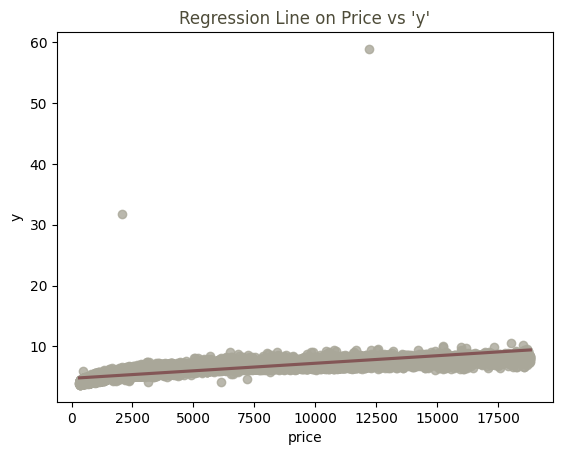

In [19]:
ax = sns.regplot(x="price", y="y", data=data, fit_reg=True, scatter_kws={"color": "#a9a799"}, line_kws={"color": "#835656"})
ax.set_title("Regression Line on Price vs 'y'", color="#4e4c39")

Text(0.5, 1.0, "Regression Line on Price vs 'z'")

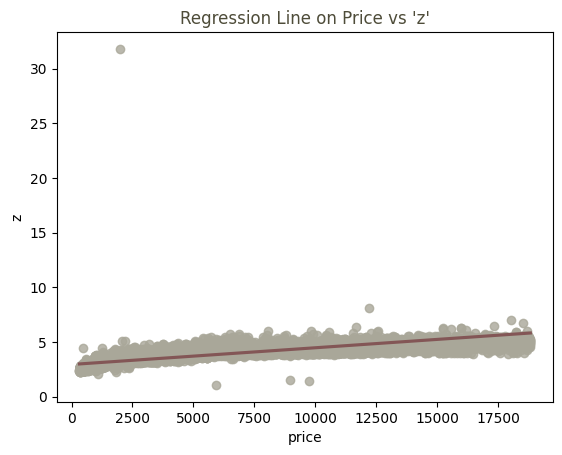

In [20]:
ax= sns.regplot(x="price", y="z", data=data, fit_reg=True, scatter_kws={"color": "#a9a799"}, line_kws={"color": "#835656"})
ax.set_title("Regression Line on Price vs 'z'", color="#4e4c39")

Text(0.5, 1.0, 'Regression Line on Price vs Depth')

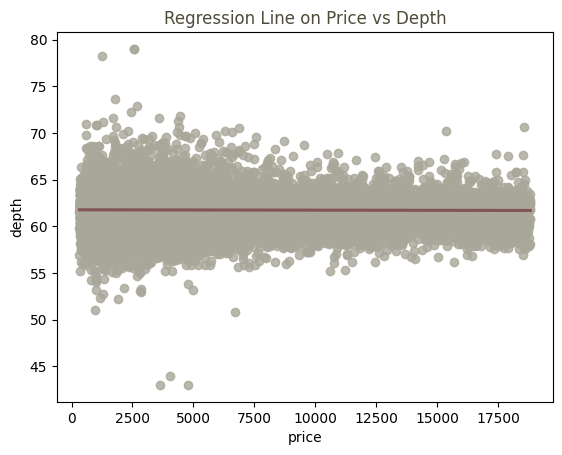

In [21]:
ax= sns.regplot(x="price", y="depth", data=data, fit_reg=True, scatter_kws={"color": "#a9a799"}, line_kws={"color": "#835656"})
ax.set_title("Regression Line on Price vs Depth", color="#4e4c39")

Text(0.5, 1.0, 'Regression Line on Price vs Table')

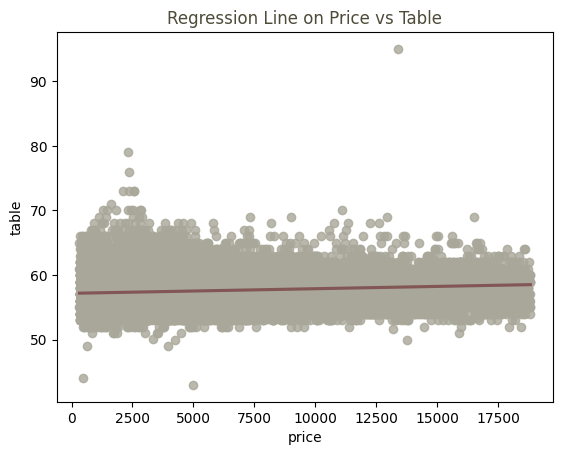

In [22]:
ax=sns.regplot(x="price", y="table", data=data, fit_reg=True, scatter_kws={"color": "#a9a799"}, line_kws={"color": "#835656"})
ax.set_title("Regression Line on Price vs Table", color="#4e4c39")

In [23]:
# 剔除離群值
data = data[(data["depth"]<75)&(data["depth"]>45)]
data = data[(data["table"]<80)&(data["table"]>40)]
data = data[(data["x"]<30)]
data = data[(data["y"]<30)]
data = data[(data["z"]<30)&(data["z"]>2)]
data.shape
# 有 8 筆資料被刪除

(53907, 10)

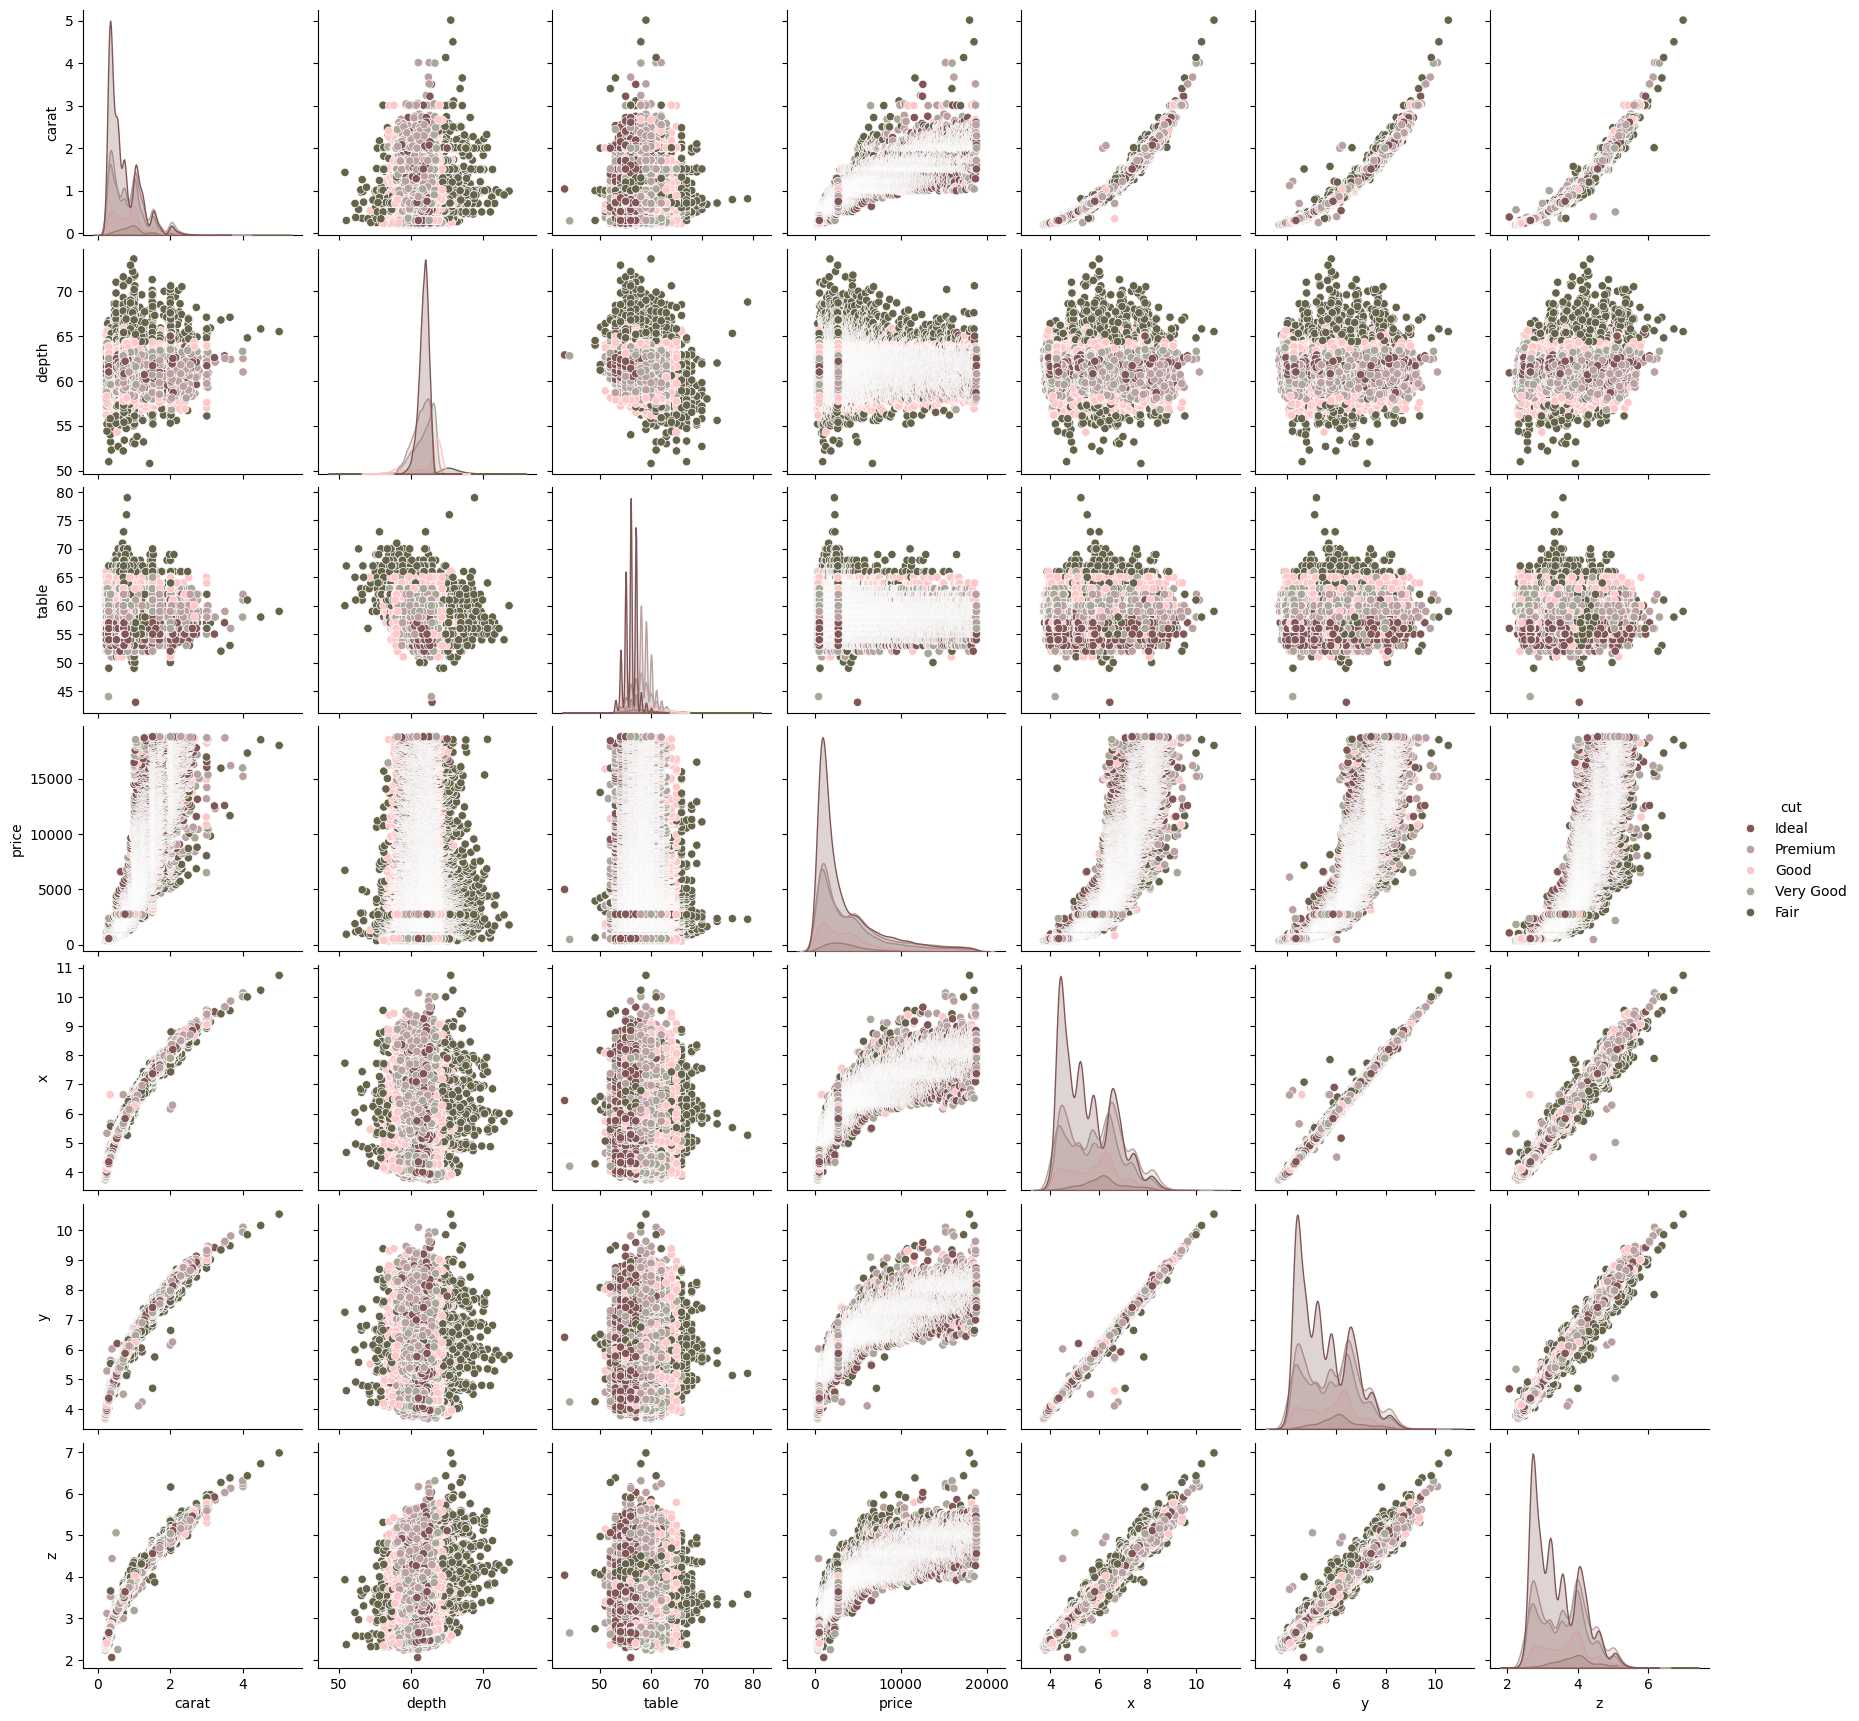

In [24]:
# 可以看到dataset變得更乾淨了
ax=sns.pairplot(data, hue= "cut",palette=shade)

In [25]:
# 看那些欄位是類別型資料
s = (data.dtypes =="object")
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['cut', 'color', 'clarity']


Text(0.5, 0, 'Cut')

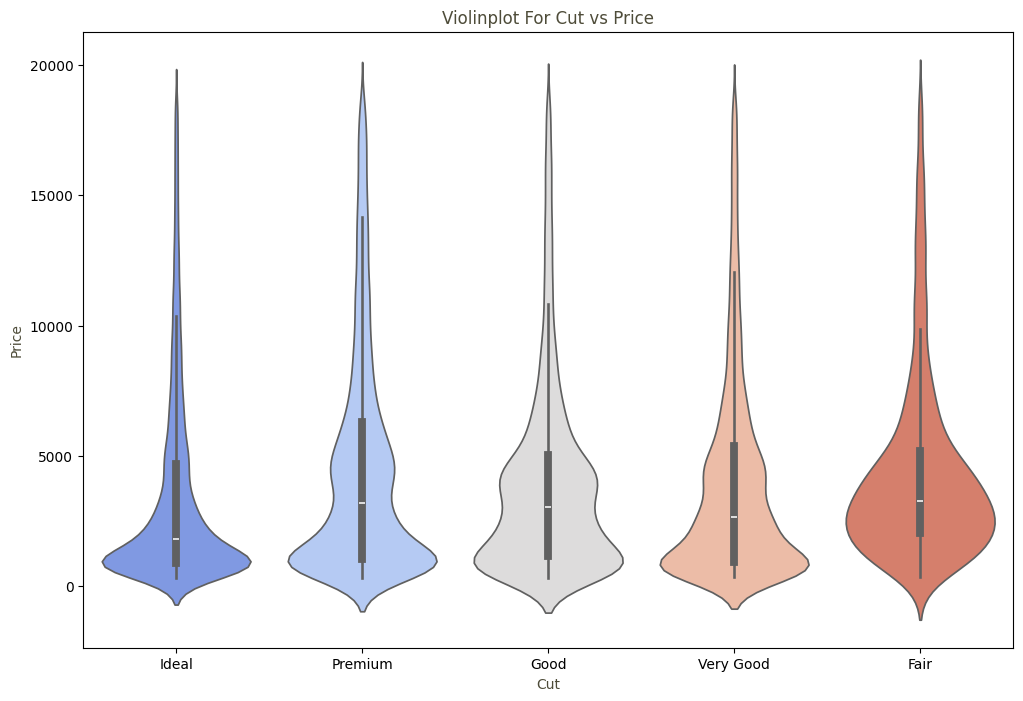

In [31]:
# 看 cut 的資料與 price 的分布。小提琴圖(violinplot) 比起盒鬚圖(boxplot)更能強調資料密集在哪
plt.figure(figsize=(12,8))
ax = sns.violinplot(
    x="cut", 
    y="price", 
    hue="cut",              # 將 x 變量分配給 hue
    data=data, 
    palette="coolwarm",     # 使用 'coolwarm' 調色盤，您可以選擇其他的調色盤
    density_norm="count",   # 小提琴圖的寬度根據樣本數量縮放
    dodge=False,            # 防止小提琴圖被分離
    legend=False            # 不顯示圖例
)
ax.set_title("Violinplot For Cut vs Price", color="#4e4c39")
ax.set_ylabel("Price", color="#4e4c39")
ax.set_xlabel("Cut", color="#4e4c39")

Text(0.5, 0, 'Color')

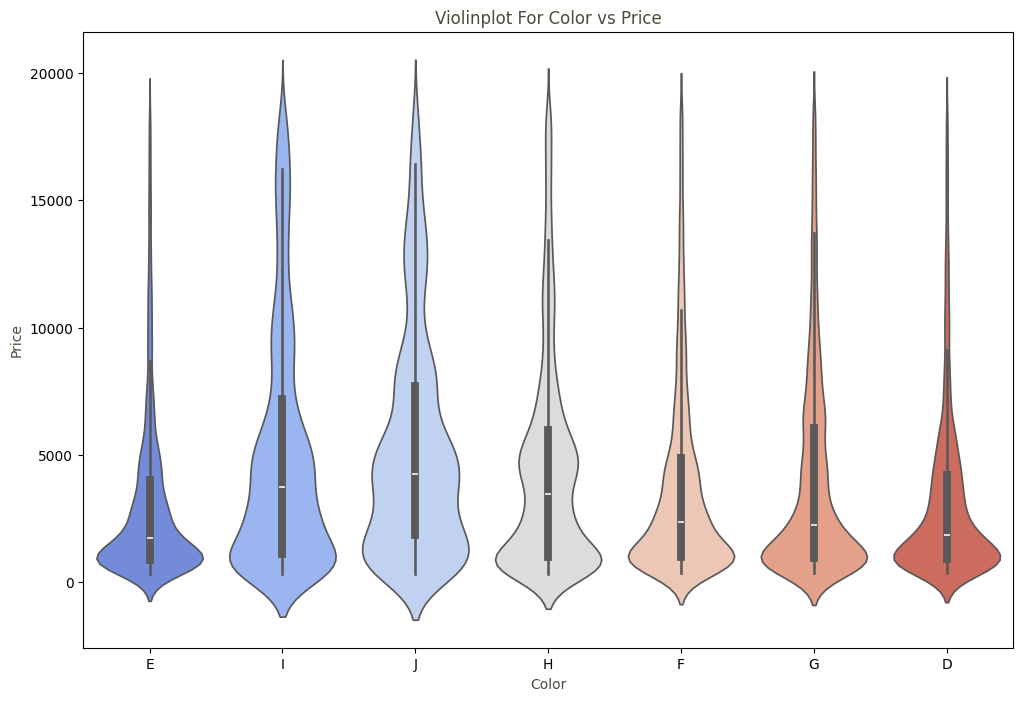

In [38]:
plt.figure(figsize=(12,8))
ax = sns.violinplot(
    x="color", 
    y="price", 
    hue="color",            # 將 x 變量分配給 hue
    data=data, 
    palette="coolwarm",     # 使用 'coolwarm' 調色盤，您可以選擇其他的調色盤
    density_norm="count",   # 小提琴圖的寬度根據樣本數量縮放
    dodge=False,            # 防止小提琴圖被分離
    legend=False            # 不顯示圖例
)
ax.set_title("Violinplot For Color vs Price", color="#4e4c39")
ax.set_ylabel("Price", color="#4e4c39")
ax.set_xlabel("Color", color="#4e4c39")

Text(0.5, 0, 'Clarity')

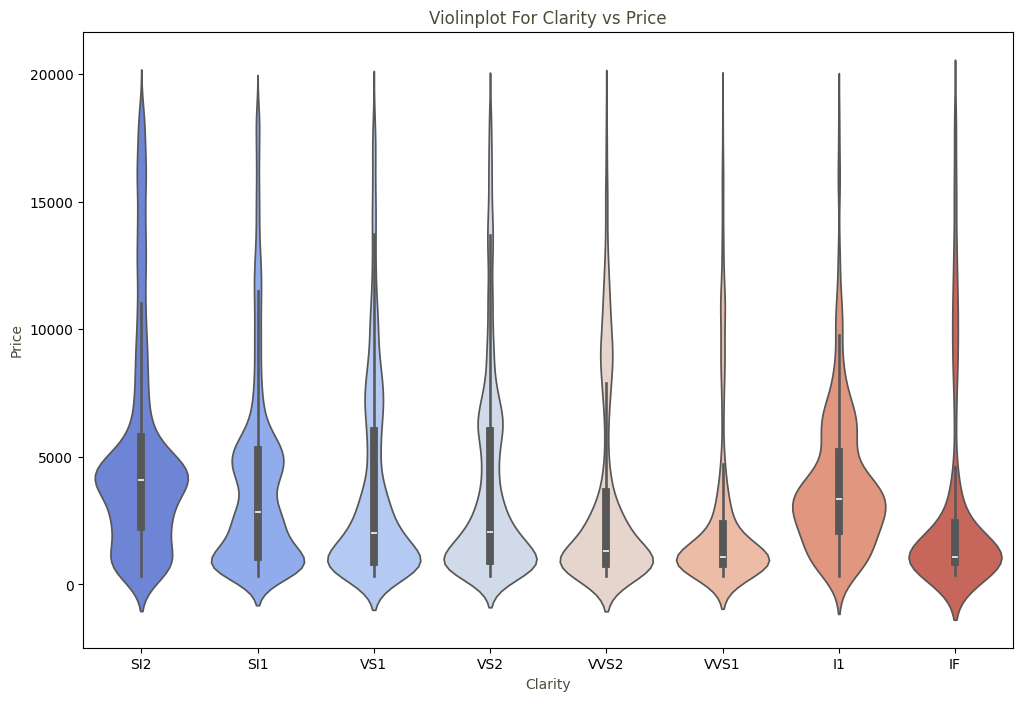

In [39]:
plt.figure(figsize=(12,8))
ax = sns.violinplot(
    x="clarity", 
    y="price", 
    hue="clarity",          # 將 x 變量分配給 hue
    data=data, 
    palette="coolwarm",     # 使用 'coolwarm' 調色盤，您可以選擇其他的調色盤
    density_norm="count",   # 小提琴圖的寬度根據樣本數量縮放
    dodge=False,            # 防止小提琴圖被分離
    legend=False            # 不顯示圖例
)
ax.set_title("Violinplot For Clarity vs Price", color="#4e4c39")
ax.set_ylabel("Price", color="#4e4c39")
ax.set_xlabel("Clarity", color="#4e4c39")

In [40]:
# Lable encoding data 複製一份 data
label_data = data.copy()

# 用 LabelEncoder 套用非數值型資料的類別上
label_encoder = LabelEncoder()
for col in object_cols:
    label_data[col] = label_encoder.fit_transform(label_data[col])
label_data.head()

carat  cut  color  clarity  depth  table  price     x     y     z
0   0.23    2      1        3   61.5   55.0    326  3.95  3.98  2.43
1   0.21    3      1        2   59.8   61.0    326  3.89  3.84  2.31
2   0.23    1      1        4   56.9   65.0    327  4.05  4.07  2.31
3   0.29    3      5        5   62.4   58.0    334  4.20  4.23  2.63
4   0.31    1      6        3   63.3   58.0    335  4.34  4.35  2.75

In [41]:
data.describe()

carat         depth         table         price             x  \
count  53907.000000  53907.000000  53907.000000  53907.000000  53907.000000   
mean       0.797628     61.749741     57.455948   3930.584470      5.731463   
std        0.473765      1.420119      2.226153   3987.202815      1.119384   
min        0.200000     50.800000     43.000000    326.000000      3.730000   
25%        0.400000     61.000000     56.000000    949.000000      4.710000   
50%        0.700000     61.800000     57.000000   2401.000000      5.700000   
75%        1.040000     62.500000     59.000000   5322.000000      6.540000   
max        5.010000     73.600000     79.000000  18823.000000     10.740000   

                  y             z  
count  53907.000000  53907.000000  
mean       5.733292      3.539441  
std        1.111252      0.691434  
min        3.680000      2.060000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6.540000      4.040000  
max       10.540000      6.980000

<Axes: >

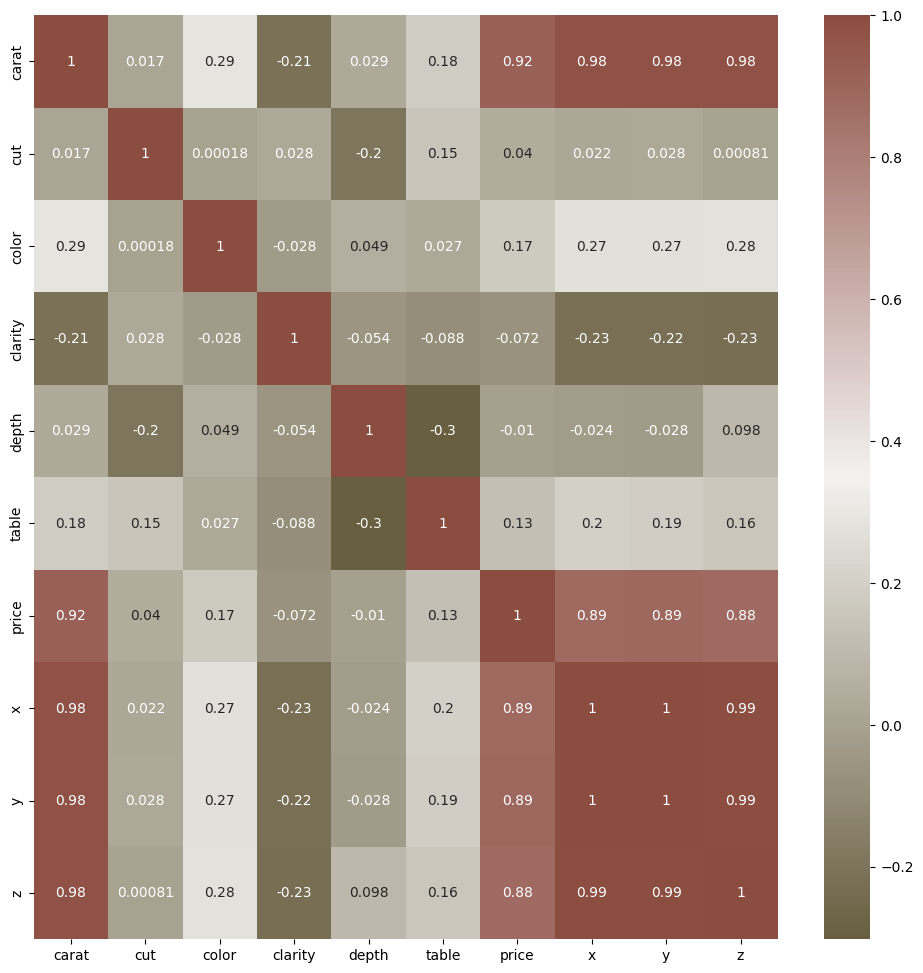

In [42]:
#correlation matrix 關係矩陣
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= label_data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

對於 price 來說 carat x y z 是有高度相關的 切工 顏色 淨度較低 可以考慮要不要使用

# 3. Model Building
模型建置
會訓練多組模型 並交叉驗證

In [44]:
# 將 dataset 拆分成訓練集和測試集 (75% train 25% test)
X= label_data.drop(["price"],axis =1)
y= label_data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=3)

In [46]:
# 使用多種不同 線性模型來做測試
pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                     ("lr_classifier",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",StandardScaler()),
                     ("dt_classifier",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                     ("rf_classifier",RandomForestRegressor())])


pipeline_kn=Pipeline([("scalar4",StandardScaler()),
                     ("rf_classifier",KNeighborsRegressor())])


pipeline_xgb=Pipeline([("scalar5",StandardScaler()),
                     ("rf_classifier",XGBRegressor())])

# 列出所有的 pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]

# 將每個 pipeline 的名稱存入字典
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGBRegressor"}

# 開始 Fit 
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [47]:
# 用 negative RMSE 來評估模型
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LinearRegression: -1350.846284 
DecisionTree: -735.218957 
RandomForest: -550.012252 
KNeighbors: -825.434319 
XGBRegressor: -540.463790 


In [48]:
# 可以看到 XGBRegressor 的 RMSE 最高
pred = pipeline_xgb.predict(X_test)

In [49]:
# Model Evaluation
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))

R^2: 0.9804545044898987
Adjusted R^2: 0.980441442229589
MAE: 279.07589053902456
MSE: 303559.2917027647
RMSE: 550.9621508804073


# 4. Finetune Model 
優化調整

In [51]:
# 嘗試拿掉更多一些欄位 只留下 x, y, z, carat 做為訓練資料 看會不會更好
X= label_data[["x","y","z","carat"]]
y= label_data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=3)

In [52]:
# 直接用 XGBRegressor 來做測試
pipeline_xgb_2=Pipeline([("scalar6",StandardScaler()),
                     ("rf_classifier",XGBRegressor())])
pipeline_xgb_2.fit(X_train, y_train)

Pipeline(steps=[('scalar6', StandardScaler()),
                ('rf_classifier',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [53]:
# 看一下 negative RMSE 有沒有更好

cv_score = cross_val_score(pipeline_xgb_2, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
cv_results_rms.append(cv_score)
print("%s: %f " % (pipe_dict[i], cv_score.mean()))

XGBRegressor: -1386.940614 


In [54]:
pred = pipeline_xgb_2.predict(X_test)

In [55]:
# Model Evaluation
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))

R^2: 0.8777216076850891
Adjusted R^2: 0.8776853017491286
MAE: 779.2824591772311
MSE: 1899092.6631072757
RMSE: 1378.0757102232358


# Conclusion
拿掉一些欄位後，模型的表現並沒有變好，被拿掉的欄位對模型還是有一定的影響
想要將模型finetune更好的畫 可能會要從模型的參數去下手，才有可能調整成更好
* 重量、體積對於鑽石的價格才是有高度的影響，切工、顏色、淨度對於價格的影響微乎其微，但在價格預測上有了這幾項特徵後 價格的預測就能變得更準確